In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e2/sample_submission.csv
/kaggle/input/playground-series-s4e2/train.csv
/kaggle/input/playground-series-s4e2/test.csv
/kaggle/input/obesitydataset-tt/ObesityDataSet (1).csv


 ## Import libraries and modules

In [2]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import OneHotEncoder, CatBoostEncoder, MEstimateEncoder
from sklearn.model_selection import StratifiedGroupKFold
import lightgbm as LGB
import catboost as cat 
import xgboost as Xgb

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.ensemble import VotingClassifier

from sklearn import set_config
import os
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import StratifiedKFold
import optuna
from sklearn.compose import ColumnTransformer
from prettytable import PrettyTable

from sklearn.compose import make_column_transformer
from sklearn.base import clone
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
pd.set_option("display.max_rows",100)
FILE_PATH = "/kaggle/input/playground-series-s4e2/"
TARGET = "NObeyesdad"
n_splits = 16
RANDOM_SEED = 150

In [3]:
import pandas as pd 

train = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')
submission = pd.read_csv('/kaggle/input/playground-series-s4e2/sample_submission.csv')
train_org = pd.read_csv('/kaggle/input/obesitydataset-tt/ObesityDataSet (1).csv')



train.shape, test.shape

((20758, 18), (13840, 17))

In [4]:
print("Train Data")
print(f"Total number of rows: {len(train)}")
print(f"Total number of columns: {train.shape[1]}\n")

print("Test Data")
print(f"Total number of rows: {len(test)}")
print(f"Total number of columns:{test.shape[1]}")

Train Data
Total number of rows: 20758
Total number of columns: 18

Test Data
Total number of rows: 13840
Total number of columns:17


## terms of this data
* 'Gender', 'Age', 'Height', 'Weight' are physical attributes
* 'family_history_with_overweight' points out to familiarity with obesity
* FAVC = Frequent consumption of high caloric food
* FCVC = Frequency of consumption of vegetables
* NCP = Number of main meals
* CAEC = Consumption of food between meals
* SMOKE = tobacco usage
* CH20 = Consumption of water daily
* SCC = Calories consumption monitoring
* FAF = Physical activity frequency
* TUE = Time using technology devices
* CALC = Consumption of alcohol
* MTRANS = Transportation used

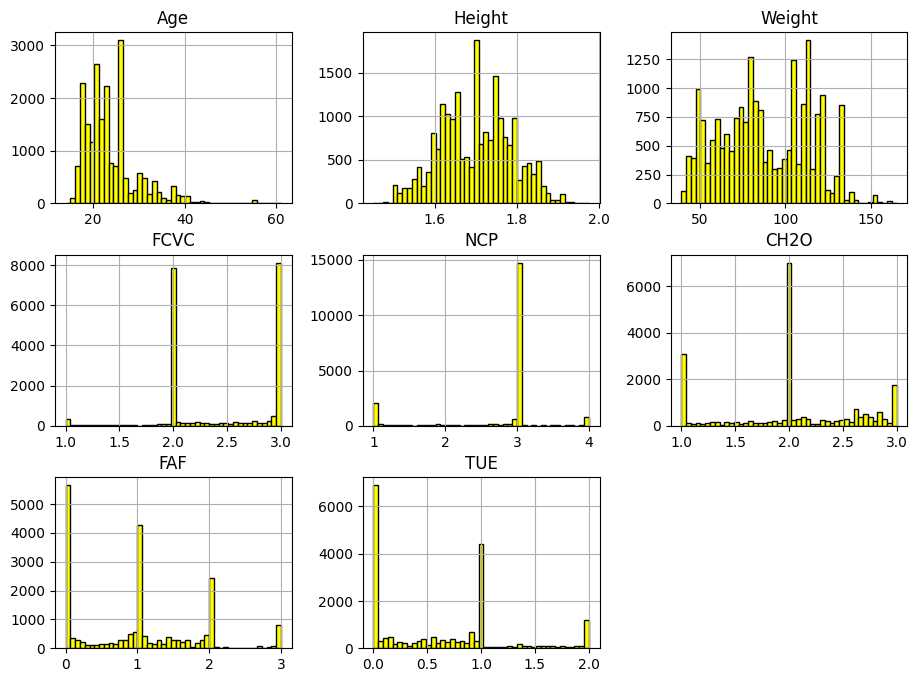

In [5]:
import matplotlib.pyplot as plt

# Select columns excluding 'id'
columns_to_plot = train.drop('id', axis=1).columns

# Plot histograms for selected columns
train[columns_to_plot].hist(bins=45, figsize=(11, 8), edgecolor="black", color="yellow")
plt.show()


## Feature Engineering 
### Firstly digging out outliers

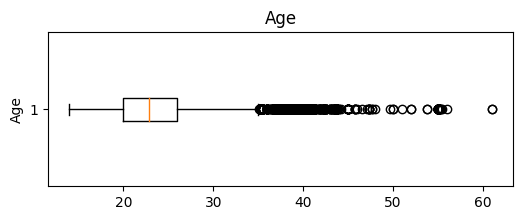

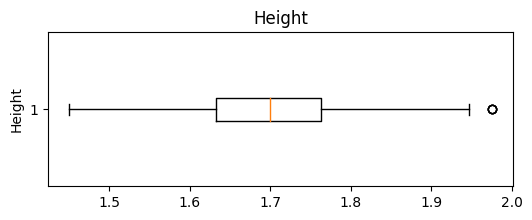

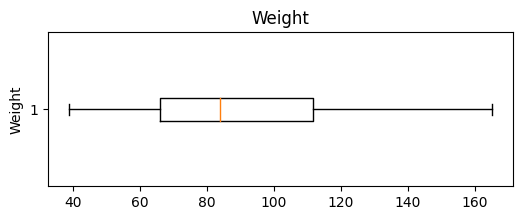

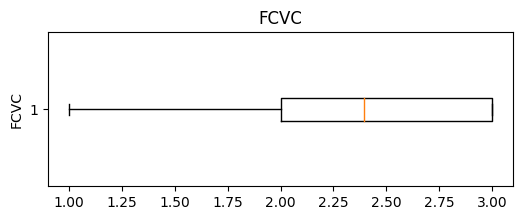

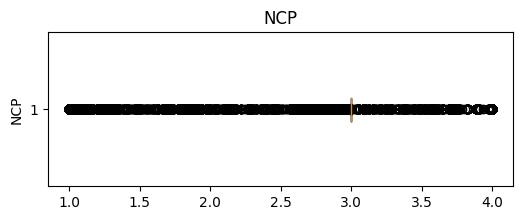

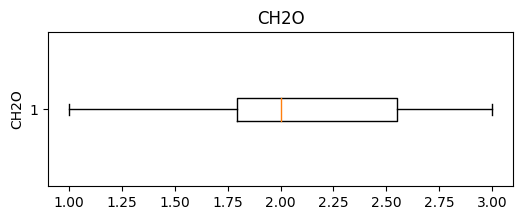

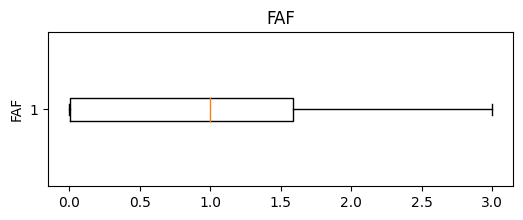

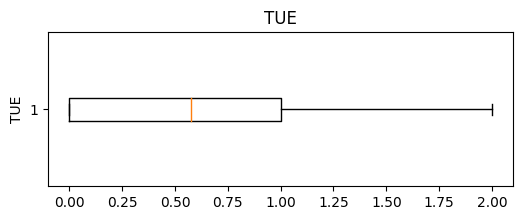

In [6]:
# Filter numerical features
numerical_columns = train.select_dtypes(include=['float64', 'int64'])

# Create box plots for each feature
for idx, col in enumerate(numerical_columns.columns[1:]):
    plt.figure(figsize=(6, 2))
    plt.boxplot(train[col], vert=False)
    plt.title(col)
#     plt.xlabel('Value')
    plt.ylabel(col)
    plt.show()

## Focusing on obesity level "NOBEYESDAD"

In [7]:
pd.set_option('display.float_format', '{:.2f}'.format) #Pandas에서 실수형 데이터를 출력할 때 소수점 둘째자리까지만 표시하도록 설정합니다.
tmp = pd.DataFrame(train.groupby([TARGET,'Gender'])["id"].agg('count')) # train 데이터를 TARGET과 Gender로 그룹화하고, 각 그룹 내의 'id' 열의 개수를 count하여 DataFrame으로 만듭니다.
tmp.columns = ['Count'] # DataFrame의 열 이름을 'Count'로 변경합니다.
train[TARGET].value_counts() # TARGET 변수의 각 클래스의 개수를 세어줍니다.
tmp = pd.merge(tmp,train[TARGET].value_counts(),left_index=True, right_index=True) # 앞서 만든 DataFrame(tmp)과 TARGET 변수의 클래스별 개수를 합칩니다.
tmp.columns = ['gender_count','target_class_count'] #  열 이름을 'gender_count'와 'target_class_count'로 변경합니다.
tmp['%gender_count'] = tmp['gender_count']/tmp['target_class_count'] # 성별별로 타겟 클래스의 비율을 계산하여 '%gender_count' 열을 추가합니다.
tmp["%target_class_count"] = tmp['target_class_count']/len(train)  # 타겟 클래스별 전체 데이터에서의 비율을 계산하여 '%target_class_count' 열을 추가합니다.
tmp = tmp[['gender_count','%gender_count','target_class_count','%target_class_count']] # 필요한 열만 남기고 다른 열은 제거합니다.
print("Target Distribution with Gender") #  출력할 내용에 대한 메시지를 출력합니다.
tmp # 최종적으로 생성된 DataFrame(tmp)을 출력합니다.

Target Distribution with Gender


gender_count  %gender_count  target_class_count  \
NObeyesdad          Gender                                                    
Insufficient_Weight Female          1621           0.64                2523   
                    Male             902           0.36                2523   
Normal_Weight       Female          1660           0.54                3082   
                    Male            1422           0.46                3082   
Obesity_Type_I      Female          1267           0.44                2910   
                    Male            1643           0.56                2910   
Obesity_Type_II     Female             8           0.00                3248   
                    Male            3240           1.00                3248   
Obesity_Type_III    Female          4041           1.00                4046   
                    Male               5           0.00                4046   
Overweight_Level_I  Female          1070           0.44                2427   
                    Male            1357           0.56                2427   
Overweight_Level_II Female           755           0.30                2522   
                    Male            1767           0.70                2522   

                            %target_class_count  
NObeyesdad          Gender                       
Insufficient_Weight Female                 0.12  
                    Male                   0.12  
Normal_Weight       Female                 0.15  
                    Male                   0.15  
Obesity_Type_I      Female                 0.14  
                    Male                   0.14  
Obesity_Type_II     Female                 0.16  
                    Male                   0.16  
Obesity_Type_III    Female                 0.19  
                    Male                   0.19  
Overweight_Level_I  Female                 0.12  
                    Male                   0.12  
Overweight_Level_II Female                 0.12  
                    Male                   0.12

## Visualize Target Distribution 

### Histogram and Pie Chart by Gender

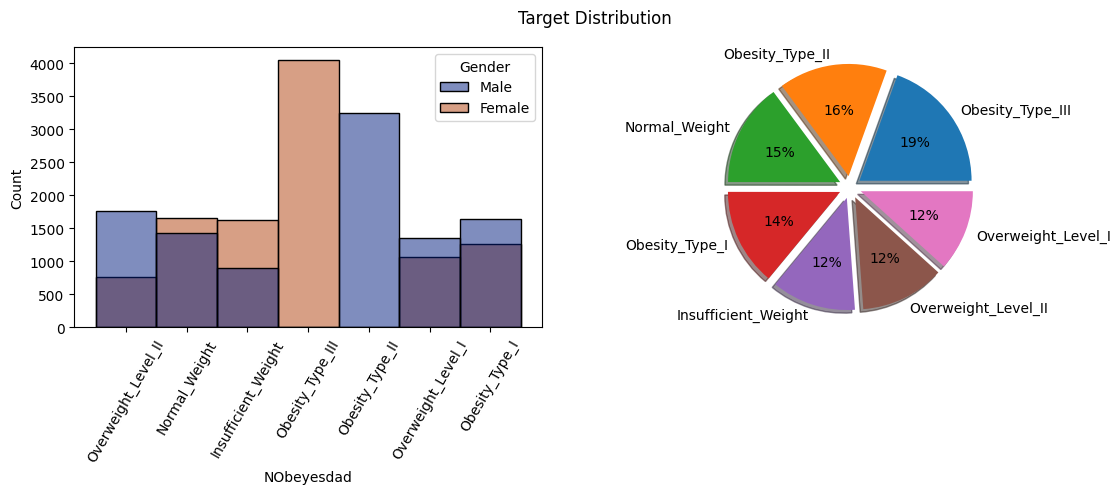

In [8]:
raw_num_cols = list(train.select_dtypes("float").columns) 
raw_cat_cols = list(train.columns.drop(raw_num_cols+[TARGET]))

full_form = dict({'FAVC' : "Frequent consumption of high caloric food",
                  'FCVC' : "Frequency of consumption of vegetables",
                  'NCP' :"Number of main meal",
                  'CAEC': "Consumption of food between meals",
                  'CH2O': "Consumption of water daily",
                  'SCC':  "Calories consumption monitoring",
                  'FAF': "Physical activity frequency",
                  'TUE': "Time using technology devices",
                  'CALC': "Consumption of alcohol" ,
                  'MTRANS' : "Transportation used"})
raw_num_cols = list(train.select_dtypes("float").columns) 
raw_cat_cols = list(train.columns.drop(raw_num_cols+[TARGET]))

full_form = dict({'FAVC' : "Frequent consumption of high caloric food",
                  'FCVC' : "Frequency of consumption of vegetables",
                  'NCP' :"Number of main meal",
                  'CAEC': "Consumption of food between meals",
                  'CH2O': "Consumption of water daily",
                  'SCC':  "Calories consumption monitoring",
                  'FAF': "Physical activity frequency",
                  'TUE': "Time using technology devices",
                  'CALC': "Consumption of alcohol" ,
                  'MTRANS' : "Transportation used"})
fig, axs = plt.subplots(1,2,figsize = (12,5))
plt.suptitle("Target Distribution")

sns.histplot(binwidth=0.5,x=TARGET,data=train,hue='Gender',palette="dark",ax=axs[0],discrete=True)
axs[0].tick_params(axis='x', rotation=60)

axs[1].pie(
        train[TARGET].value_counts(),
        shadow = True,
        explode=[.1 for i in range(train[TARGET].nunique())],
        labels = train[TARGET].value_counts().index,
        autopct='%1.f%%',
    )

plt.tight_layout()
plt.show()

### The Violin 

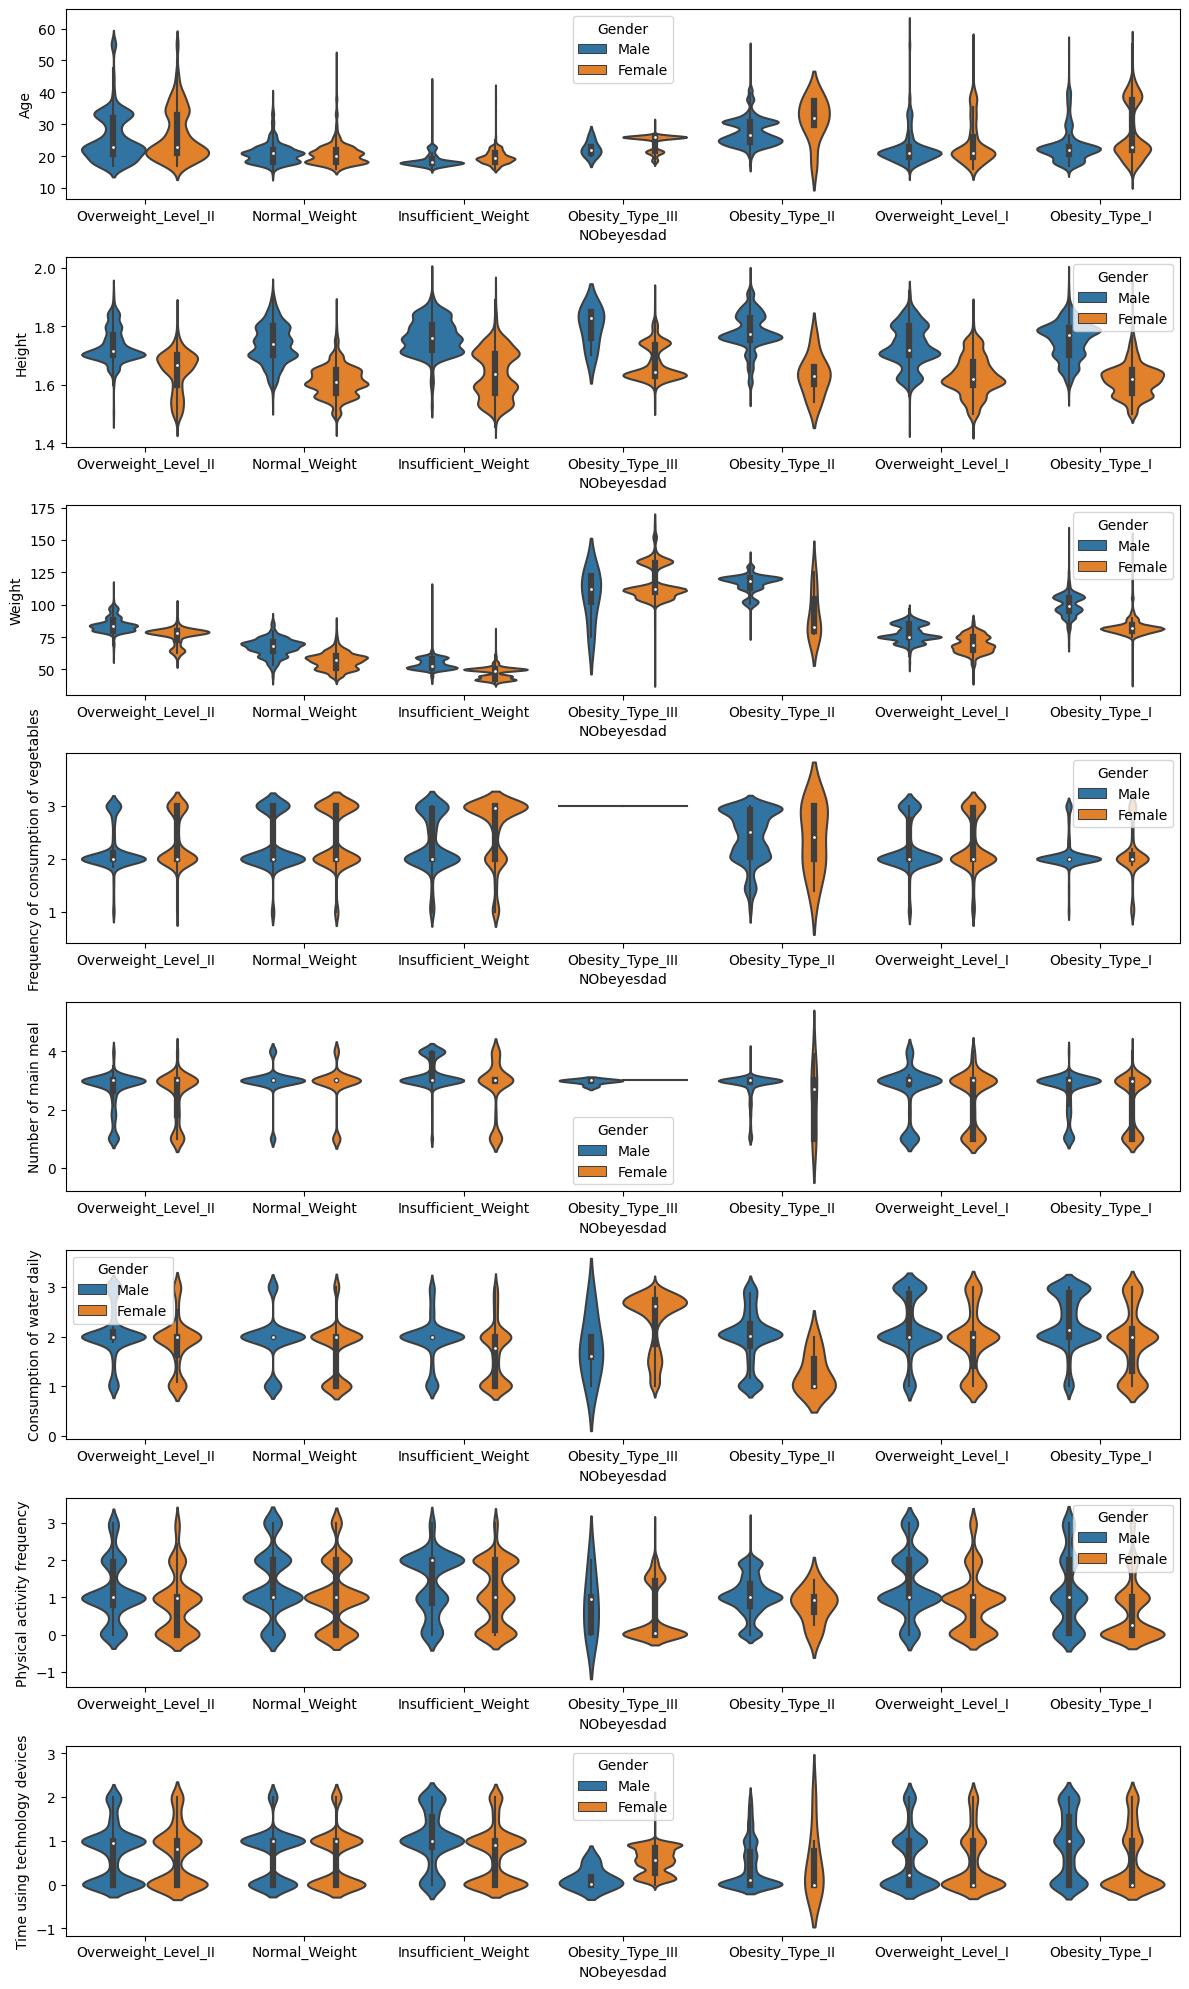

In [9]:
fig,axs = plt.subplots(len(raw_num_cols),1,figsize=(12,len(raw_num_cols)*2.5),sharex=False)
for i, col in enumerate(raw_num_cols):
    sns.violinplot(x=TARGET, y=col,hue="Gender", data=train,ax = axs[i], split=False)
    if col in full_form.keys():
        axs[i].set_ylabel(full_form[col])

plt.tight_layout()
plt.show()

### Countplot according to specific cases

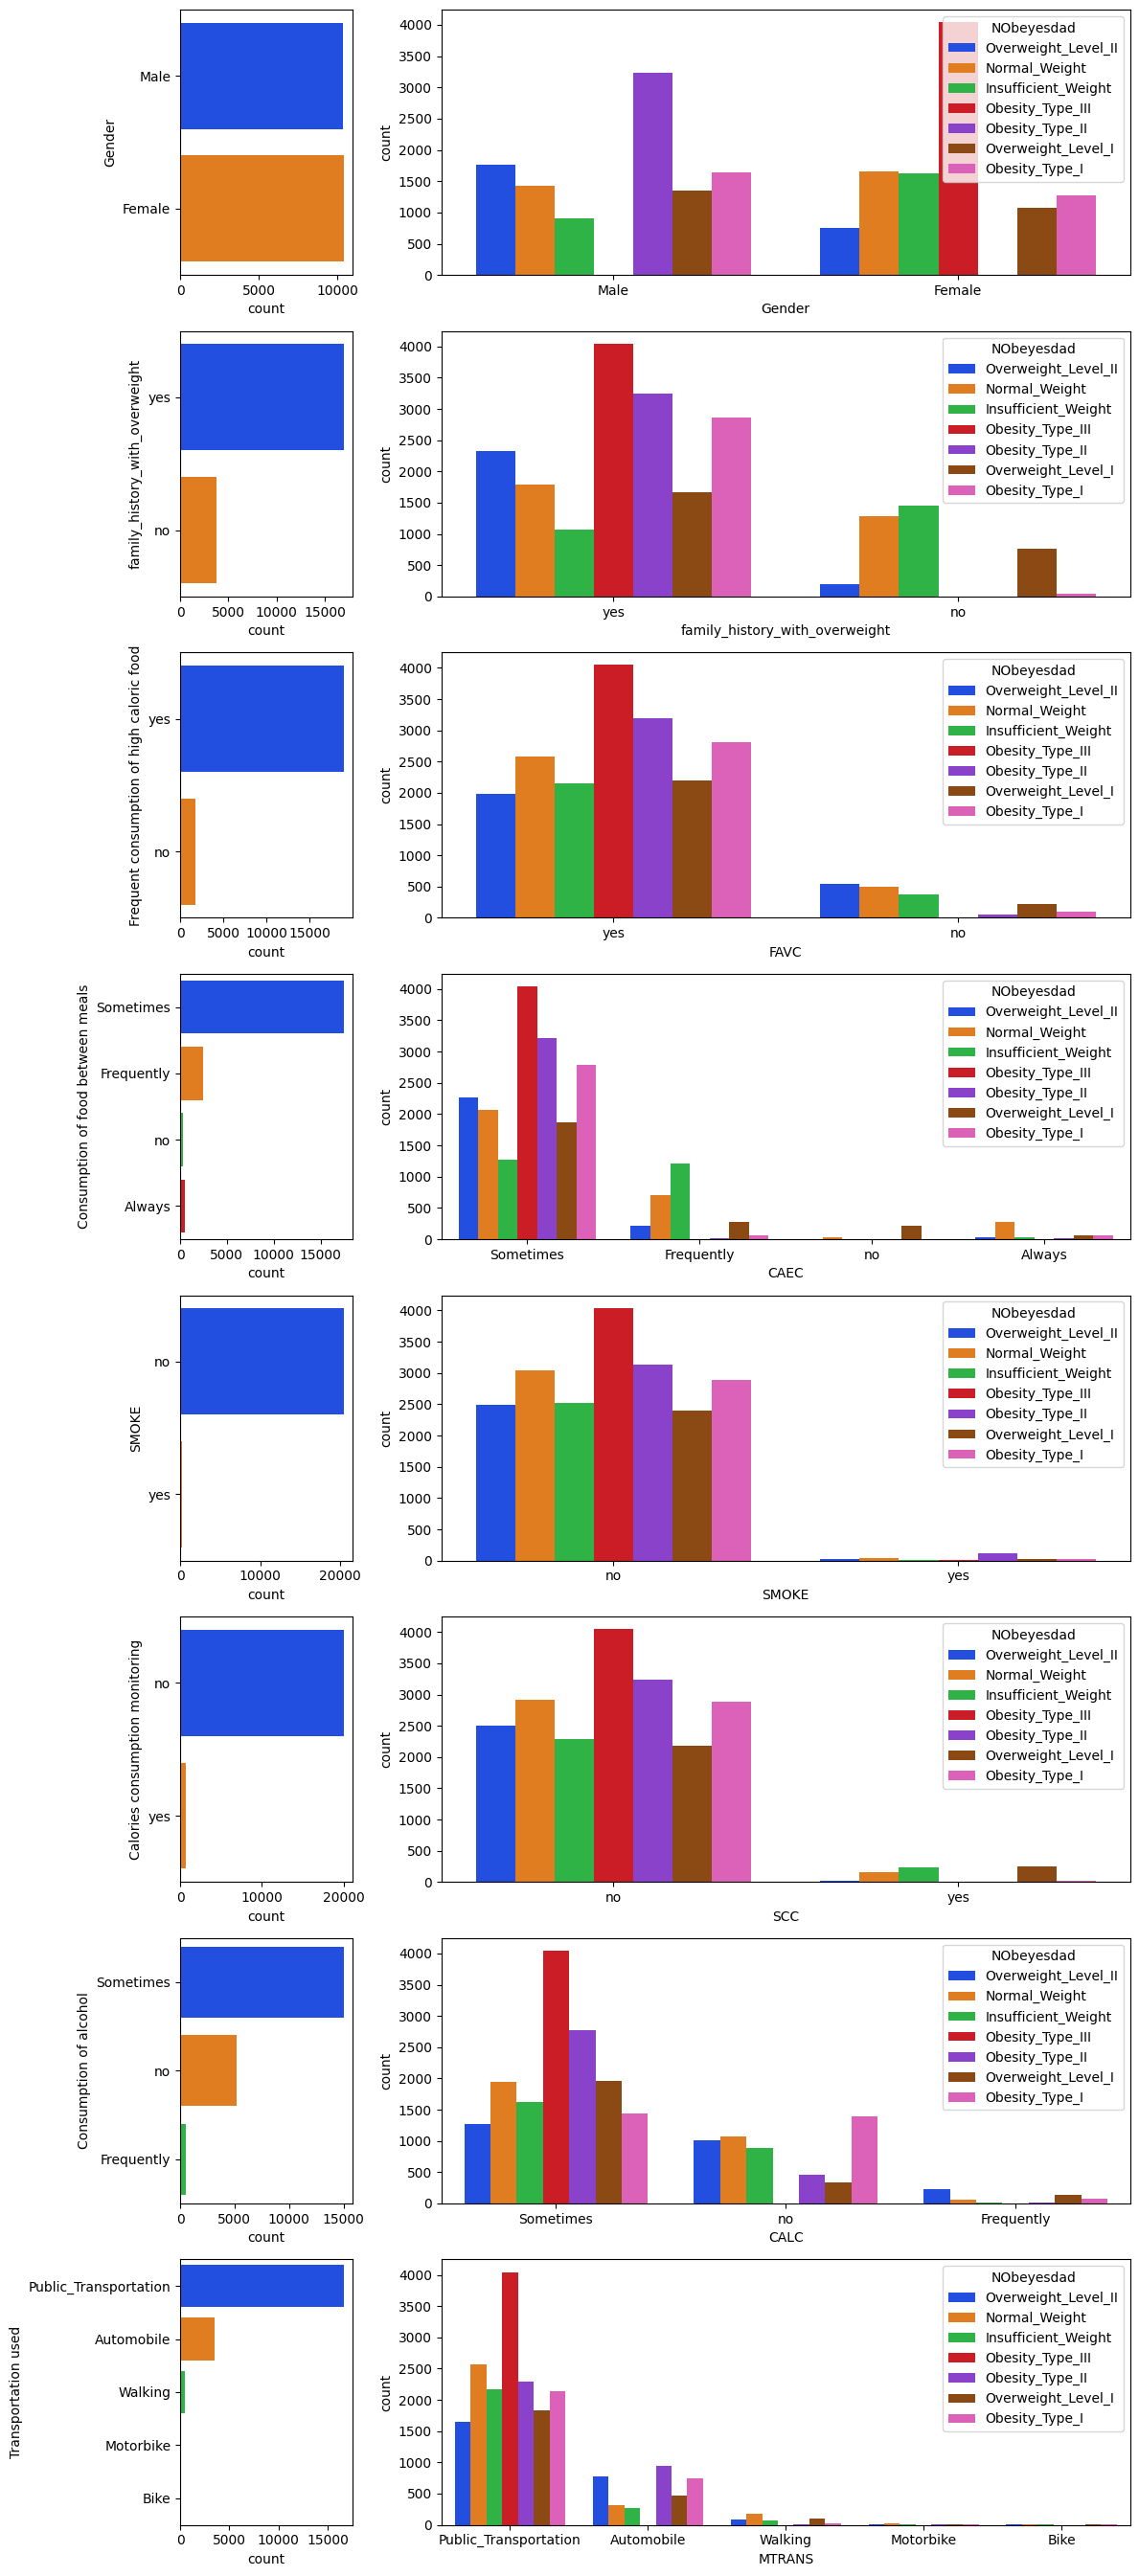

In [10]:
_,axs = plt.subplots(int(len(raw_cat_cols)-1),2,figsize=(12,len(raw_cat_cols)*3),width_ratios=[1, 4])
for i,col in enumerate(raw_cat_cols[1:]):
    sns.countplot(y=col,data=train,palette="bright",ax=axs[i,0])
    sns.countplot(x=col,data=train,hue=TARGET,palette="bright",ax=axs[i,1])
    if col in full_form.keys():
        axs[i,0].set_ylabel(full_form[col])


plt.tight_layout()
plt.show()

### Pearson correlation heatmap 

<Axes: >

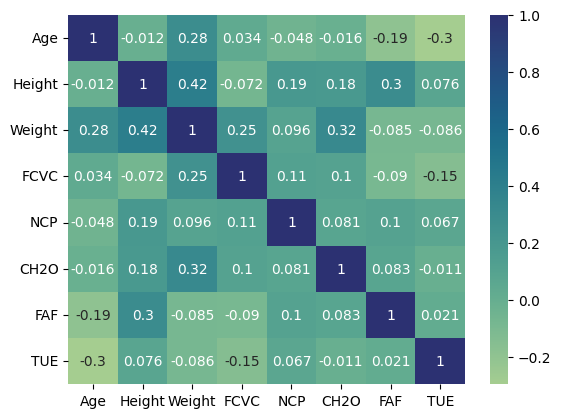

In [11]:
tmp = train[raw_num_cols].corr("pearson")
sns.heatmap(tmp,annot=True,cmap ="crest")

## Modeling with Unsupervised Learning
### Exploring Data Analysis through PCA and K-means Clustering

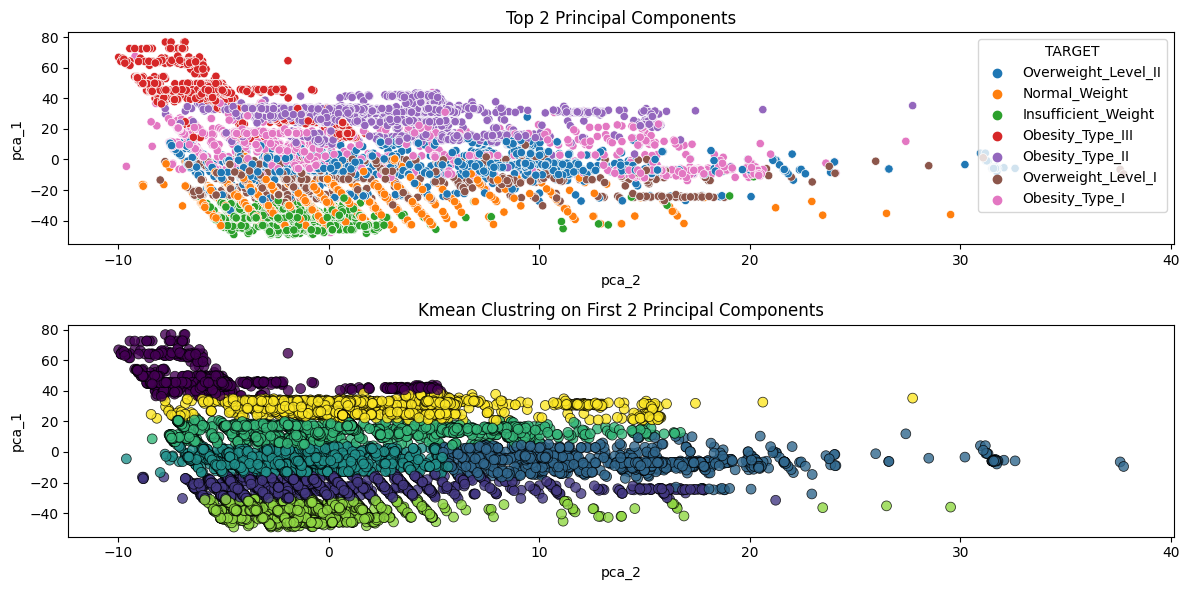

In [12]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

#PCA
pca = PCA(n_components=2)
pca_top_2 = pca.fit_transform(train[raw_num_cols])

tmp = pd.DataFrame(data = pca_top_2, columns = ['pca_1','pca_2'])
tmp['TARGET'] = train[TARGET]

fig,axs = plt.subplots(2,1,figsize = (12,6))
sns.scatterplot(data=tmp, y="pca_1", x="pca_2", hue='TARGET',ax=axs[0])
axs[0].set_title("Top 2 Principal Components")

#KMeans
kmeans = KMeans(7,random_state=RANDOM_SEED)
kmeans.fit(tmp[['pca_1','pca_2']])
sns.scatterplot( y= tmp['pca_1'],x = tmp['pca_2'],c = kmeans.labels_,cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.8,ax = axs[1])
axs[1].set_title("Kmean Clustring on First 2 Principal Components")
plt.tight_layout()
plt.show()

### Basic Construction for Pipeline Transformation

In [13]:
def age_rounder(x):
    x_copy = x.copy()
    x_copy['Age'] = (x_copy['Age']*100).astype(np.uint16)
    return x_copy

def height_rounder(x):
    x_copy = x.copy()
    x_copy['Height'] = (x_copy['Height']*100).astype(np.uint16)
    return x_copy

def extract_features(x):
    x_copy = x.copy()
    x_copy['BMI'] = (x_copy['Weight']/x_copy['Height']**2)
#     x_copy['PseudoTarget'] = pd.cut(x_copy['BMI'],bins = [0,18.4,24.9,29,34.9,39.9,100],labels = [0,1,2,3,4,5],)    
    return x_copy

def col_rounder(x):
    x_copy = x.copy()
    cols_to_round = ['FCVC',"NCP","CH2O","FAF","TUE"]
    for col in cols_to_round:
        x_copy[col] = round(x_copy[col])
        x_copy[col] = x_copy[col].astype('int')
    return x_copy

AgeRounder = FunctionTransformer(age_rounder)
HeightRounder = FunctionTransformer(height_rounder)
ExtractFeatures = FunctionTransformer(extract_features)
ColumnRounder = FunctionTransformer(col_rounder)
from sklearn.base import BaseEstimator, TransformerMixin
class FeatureDropper(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
    def fit(self,x,y):
        return self
    def transform(self, x):
        return x.drop(self.cols, axis = 1)

### Cross-Validation with Ensemble Model

In [14]:
target_mapping = {
                  'Insufficient_Weight':0,
                  'Normal_Weight':1,
                  'Overweight_Level_I':2,
                  'Overweight_Level_II':3, 
                  'Obesity_Type_I':4,
                  'Obesity_Type_II':5 ,
                  'Obesity_Type_III':6
                  }

# Define a method for Cross validation here we are using StartifiedKFold
skf = StratifiedKFold(n_splits=n_splits)

def cross_val_model(estimators,cv = skf, verbose = True):
    '''
        estimators : pipeline consists preprocessing, encoder & model
        cv : Method for cross validation (default: StratifiedKfold)
        verbose : print train/valid score (yes/no)
    '''
    
    X = train.copy()
    y = X.pop(TARGET)

    y = y.map(target_mapping)
    test_predictions = np.zeros((len(test),7))
    valid_predictions = np.zeros((len(X),7))

    val_scores, train_scores = [],[]
    for fold, (train_ind, valid_ind) in enumerate(skf.split(X,y)):
        model = clone(estimators)
        #define train set
        X_train = X.iloc[train_ind]
        y_train = y.iloc[train_ind]
        #define valid set
        X_valid = X.iloc[valid_ind]
        y_valid = y.iloc[valid_ind]

        model.fit(X_train, y_train)
        if verbose:
            print("-" * 100)
            print(f"Fold: {fold}")
            print(f"Train Accuracy Score:-{accuracy_score(y_true=y_train,y_pred=model.predict(X_train))}")
            print(f"Valid Accuracy Score:-{accuracy_score(y_true=y_valid,y_pred=model.predict(X_valid))}")
            print("-" * 100)

        
        test_predictions += model.predict_proba(test)/cv.get_n_splits()
        valid_predictions[valid_ind] = model.predict_proba(X_valid)
        val_scores.append(accuracy_score(y_true=y_valid,y_pred=model.predict(X_valid)))
    if verbose: 
        print(f"Average Mean Accuracy Score:- {np.array(val_scores).mean()}")
    return val_scores, valid_predictions, test_predictions
train.drop(['id'],axis = 1, inplace = True)
test_ids = test['id']
test.drop(['id'],axis = 1, inplace=True)

train = pd.concat([train,train_org],axis = 0)
train = train.drop_duplicates()
train.reset_index(drop=True, inplace=True)
score_list, oof_list, predict_list = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

### Random Forest 

In [15]:
RFC = make_pipeline(
                        ExtractFeatures,
                        MEstimateEncoder(cols=['Gender','family_history_with_overweight','FAVC','CAEC',
                                           'SMOKE','SCC','CALC','MTRANS']),
                       RandomForestClassifier(random_state=RANDOM_SEED)
                    )
val_scores,val_predictions,test_predictions = cross_val_model(RFC)

# Save train/test predictions in dataframes
for k,v in target_mapping.items():
    oof_list[f"rfc_{k}"] = val_predictions[:,v]

for k,v in target_mapping.items():
    predict_list[f"rfc_{k}"] = test_predictions[:,v]

----------------------------------------------------------------------------------------------------
Fold: 0
Train Accuracy Score:-0.9998599243591539
Valid Accuracy Score:-0.8942577030812325
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 1
Train Accuracy Score:-0.9998599243591539
Valid Accuracy Score:-0.8914565826330533
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 2
Train Accuracy Score:-0.999906616239436
Valid Accuracy Score:-0.8977591036414566
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 3
Train Accuracy S

### LightGBM Hyperparameter Tuning using Optuna

In [16]:
def lgbm_objective(trial):
    params = {
        'learning_rate' : trial.suggest_float('learning_rate', .001, .1, log = True),
        'max_depth' : trial.suggest_int('max_depth', 2, 20),
        'subsample' : trial.suggest_float('subsample', .5, 1),
        'min_child_weight' : trial.suggest_float('min_child_weight', .1, 15, log = True),
        'reg_lambda' : trial.suggest_float('reg_lambda', .1, 20, log = True),
        'reg_alpha' : trial.suggest_float('reg_alpha', .1, 10, log = True),
        'n_estimators' : 1000,
        'random_state' : RANDOM_SEED,
        'device_type' : "gpu",
        'num_leaves': trial.suggest_int('num_leaves', 10, 1000),

        #'boosting_type' : 'dart',
    }
    
    optuna_model = make_pipeline(
                                 ExtractFeatures,
                                 MEstimateEncoder(cols=['Gender','family_history_with_overweight','FAVC','CAEC',
                                           'SMOKE','SCC','CALC','MTRANS']),
                                LGBMClassifier(**params,verbose=-1)
                                )
    val_scores, _, _ = cross_val_model(optuna_model,verbose = False)
    return np.array(val_scores).mean()

lgbm_study = optuna.create_study(direction = 'maximize',study_name="LGBM")

[I 2024-02-29 16:13:51,420] A new study created in memory with name: LGBM


### LightGBM with Hyperparameter Tuning

In [17]:
TUNE = False

warnings.filterwarnings("ignore")
if TUNE:
    lgbm_study.optimize(lgbm_objective, 50)
numerical_columns = train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = train.select_dtypes(include=['object']).columns.tolist()
categorical_columns.remove('NObeyesdad')
params = {'learning_rate': 0.04325905707439143, 'max_depth': 4, 
          'subsample': 0.6115083405793659, 'min_child_weight': 0.43633356137010687, 
          'reg_lambda': 9.231766981717822, 'reg_alpha': 1.875987414096491, 'num_leaves': 373,
          'n_estimators' : 1000,'random_state' : RANDOM_SEED, 'device_type' : "gpu",
         }

best_params = {
    "objective": "multiclass",          # Objective function for the model
    "metric": "multi_logloss",          # Evaluation metric
    "verbosity": -1,                    # Verbosity level (-1 for silent)
    "boosting_type": "gbdt",            # Gradient boosting type
    "random_state": 42,       # Random state for reproducibility
    "num_class": 7,                     # Number of classes in the dataset
    'learning_rate': 0.030962211546832760,  # Learning rate for gradient boosting
    'n_estimators': 500,                # Number of boosting iterations
    'lambda_l1': 0.009667446568254372,  # L1 regularization term
    'lambda_l2': 0.04018641437301800,   # L2 regularization term
    'max_depth': 10,                    # Maximum depth of the trees
    'colsample_bytree': 0.40977129346872643,  # Fraction of features to consider for each tree
    'subsample': 0.9535797422450176,    # Fraction of samples to consider for each boosting iteration
    'min_child_samples': 26             # Minimum number of data needed in a leaf
}

lgbm = make_pipeline(    
                        ColumnTransformer(
                        transformers=[('num', StandardScaler(), numerical_columns),
                                  ('cat', OneHotEncoder(handle_unknown="ignore"), categorical_columns)]),
                        LGBMClassifier(**best_params,verbose=-1)
                    )
val_scores,val_predictions,test_predictions = cross_val_model(lgbm)

for k,v in target_mapping.items():
    oof_list[f"lgbm_{k}"] = val_predictions[:,v]
    
for k,v in target_mapping.items():
    predict_list[f"lgbm_{k}"] = test_predictions[:,v]

----------------------------------------------------------------------------------------------------
Fold: 0
Train Accuracy Score:-0.9764672923378624
Valid Accuracy Score:-0.9019607843137255
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 1
Train Accuracy Score:-0.9756268384927861
Valid Accuracy Score:-0.9180672268907563
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 2
Train Accuracy Score:-0.9758136060139142
Valid Accuracy Score:-0.9047619047619048
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 3
Train Accuracy 

### XGBoost Hyperparameter Tuning

In [18]:
def xgb_objective(trial):
    params = {
        'grow_policy': trial.suggest_categorical('grow_policy', ["depthwise", "lossguide"]),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'gamma' : trial.suggest_float('gamma', 1e-9, 1.0),
        'subsample': trial.suggest_float('subsample', 0.25, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.25, 1.0),
        'max_depth': trial.suggest_int('max_depth', 0, 24),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 30),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
    }

    params['booster'] = 'gbtree'
    params['objective'] = 'multi:softmax'
    params["device"] = "cuda"
    params["verbosity"] = 0
    params['tree_method'] = "gpu_hist"
    
    
    optuna_model = make_pipeline(
#                     ExtractFeatures,
                    MEstimateEncoder(cols=['Gender','family_history_with_overweight','FAVC','CAEC',
                                           'SMOKE','SCC','CALC','MTRANS']),
                    XGBClassifier(**params,seed=RANDOM_SEED)
                   )
    
    val_scores, _, _ = cross_val_model(optuna_model,verbose = False)
    return np.array(val_scores).mean()

xgb_study = optuna.create_study(direction = 'maximize')

[I 2024-02-29 16:18:22,938] A new study created in memory with name: no-name-2e6e5d79-31ef-4cfe-8d4d-b98b2b536cab


### XGBoost; further and beyond, conjure up the prediction

In [19]:
TUNE = False
if TUNE:
    xgb_study.optimize(xgb_objective, 50)
params = {
    'n_estimators': 1312,
    'learning_rate': 0.018279520260162645,
    'gamma': 0.0024196354156454324,
    'reg_alpha': 0.9025931173755949,
    'reg_lambda': 0.06835667255875388,
    'max_depth': 5,
    'min_child_weight': 5,
    'subsample': 0.883274050086088,
    'colsample_bytree': 0.6579828557036317
}
# {'eta': 0.018387615982905264, 'max_depth': 29, 'subsample': 0.8149303101087905, 'colsample_bytree': 0.26750463604831476, 'min_child_weight': 0.5292380065098192, 'reg_lambda': 0.18952063379457604, 'reg_alpha': 0.7201451827004944}

params = {'grow_policy': 'depthwise', 'n_estimators': 690, 
               'learning_rate': 0.31829021594473056, 'gamma': 0.6061120644431842, 
               'subsample': 0.9032243794829076, 'colsample_bytree': 0.44474031945048287,
               'max_depth': 10, 'min_child_weight': 22, 'reg_lambda': 4.42638097284094,
               'reg_alpha': 5.927900973354344e-07,'seed':RANDOM_SEED}

best_params = {'grow_policy': 'depthwise', 'n_estimators': 982, 
               'learning_rate': 0.050053726931263504, 'gamma': 0.5354391952653927, 
               'subsample': 0.7060590452456204, 'colsample_bytree': 0.37939433412123275, 
               'max_depth': 23, 'min_child_weight': 21, 'reg_lambda': 9.150224029846654e-08,
               'reg_alpha': 5.671063656994295e-08}
best_params['booster'] = 'gbtree'
best_params['objective'] = 'multi:softmax'
best_params["device"] = "cuda"
best_params["verbosity"] = 0
best_params['tree_method'] = "gpu_hist"
    
XGB = make_pipeline(

                    MEstimateEncoder(cols=['Gender','family_history_with_overweight','FAVC','CAEC',
                                           'SMOKE','SCC','CALC','MTRANS']),
                    XGBClassifier(**best_params,seed=RANDOM_SEED)
                   )
val_scores,val_predictions,test_predictions = cross_val_model(XGB)

for k,v in target_mapping .items():
    oof_list[f"xgb_{k}"] = val_predictions[:,v]

for k,v in target_mapping.items():
    predict_list[f"xgb_{k}"] = test_predictions[:,v]

----------------------------------------------------------------------------------------------------
Fold: 0
Train Accuracy Score:-0.9450903487883457
Valid Accuracy Score:-0.9068627450980392
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 1
Train Accuracy Score:-0.9442032030629873
Valid Accuracy Score:-0.9131652661064426
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 2
Train Accuracy Score:-0.9450903487883457
Valid Accuracy Score:-0.9033613445378151
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 3
Train Accuracy 

### Define method for CatBoost parameter tuning

In [20]:
def cat_objective(trial):
    
    params = {
        
        'iterations': 1000,  # High number of estimators
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.01, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_seed': RANDOM_SEED,
        'verbose': False,
        'task_type':"GPU"
    }
    
    cat_features = ['Gender','family_history_with_overweight','FAVC','FCVC','NCP',
                'CAEC','SMOKE','CH2O','SCC','FAF','TUE','CALC','MTRANS']
    optuna_model = make_pipeline(
                        ExtractFeatures,
#                         AgeRounder,
#                         HeightRounder,
#                         MEstimateEncoder(cols = raw_cat_cols),
                        CatBoostClassifier(**params,cat_features=cat_features)
                        )
    val_scores,_,_ = cross_val_model(optuna_model,verbose = False)
    return np.array(val_scores).mean()
    
cat_study = optuna.create_study(direction = 'maximize')

[I 2024-02-29 16:20:54,896] A new study created in memory with name: no-name-128f762b-cfbc-4304-84c4-3bdcc169b842


### Predictions Using the CatBoost Model

In [21]:
params = {'learning_rate': 0.13762007048684638, 'depth': 5, 
          'l2_leaf_reg': 5.285199432056192, 'bagging_temperature': 0.6029582154263095,
         'random_seed': RANDOM_SEED,
        'verbose': False,
        'task_type':"GPU",
         'iterations':1000}


CB = make_pipeline(

                        CatBoostClassifier(**params, cat_features=categorical_columns)
                        )
val_scores,val_predictions,test_predictions = cross_val_model(CB)
for k,v in target_mapping.items():
    oof_list[f"cat_{k}"] = val_predictions[:,v]

for k,v in target_mapping.items():
    predict_list[f"cat_{k}"] = test_predictions[:,v]

----------------------------------------------------------------------------------------------------
Fold: 0
Train Accuracy Score:-0.9484988560489331
Valid Accuracy Score:-0.9110644257703081
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 1
Train Accuracy Score:-0.9470514077601905
Valid Accuracy Score:-0.9068627450980392
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 2
Train Accuracy Score:-0.9491058504925993
Valid Accuracy Score:-0.8998599439775911
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 3
Train Accuracy 

## Evaluation & Submission 

Ensemble Accuracy Scoe: 0.9176187349529438


<Figure size 800x800 with 0 Axes>

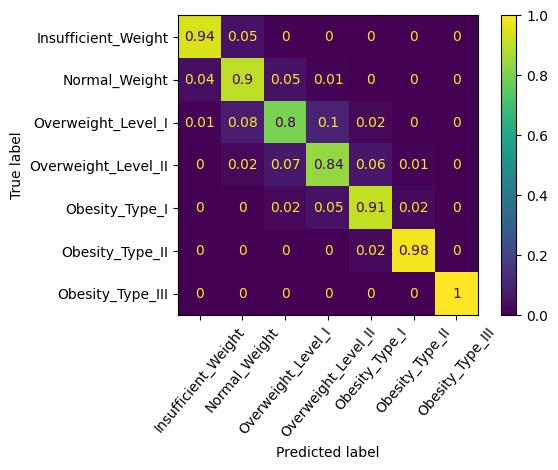

In [22]:
skf = StratifiedKFold(n_splits=5)

weights = {"rfc_":0,
           "lgbm_":3,
           "xgb_":1,
           "cat_":0}
tmp = oof_list.copy()
for k,v in target_mapping.items():
    tmp[f"{k}"] = (weights['rfc_']*tmp[f"rfc_{k}"] +
              weights['lgbm_']*tmp[f"lgbm_{k}"]+
              weights['xgb_']*tmp[f"xgb_{k}"]+
              weights['cat_']*tmp[f"cat_{k}"])    
tmp['pred'] = tmp[target_mapping.keys()].idxmax(axis = 1)
tmp['label'] = train[TARGET]
print(f"Ensemble Accuracy Scoe: {accuracy_score(train[TARGET],tmp['pred'])}")
    
cm = confusion_matrix(y_true = tmp['label'].map(target_mapping),
                      y_pred = tmp['pred'].map(target_mapping),
                     normalize='true')

cm = cm.round(2)
plt.figure(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = target_mapping.keys())
disp.plot(xticks_rotation=50)
plt.tight_layout()
plt.show()

In [23]:
for k,v in target_mapping.items():
    predict_list[f"{k}"] = (weights['rfc_']*predict_list[f"rfc_{k}"]+
                            weights['lgbm_']*predict_list[f"lgbm_{k}"]+
                            weights['xgb_']*predict_list[f"xgb_{k}"]+
                            weights['cat_']*predict_list[f"cat_{k}"])

final_pred = predict_list[target_mapping.keys()].idxmax(axis = 1)

submission[TARGET] = final_pred
submission.to_csv("/kaggle/working/submission.csv",index=False)
submission

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III
...,...,...
13835,34593,Overweight_Level_II
13836,34594,Normal_Weight
13837,34595,Insufficient_Weight
13838,34596,Normal_Weight
